In [137]:
%load_ext line_profiler

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import celerite
from celerite import modeling, terms
from rotate.rotation_term import MixtureTerm

In [4]:
from itertools import combinations_with_replacement
from scipy.signal import savgol_filter
from astropy.stats import LombScargle
from emcee.autocorr import function_1d
from scipy.ndimage.filters import gaussian_filter
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize


def ls_period(t, flux, min_period, max_period):
    """Estimate the period using a LS periodogram"""
    freq = np.linspace(1.0 / max_period, 1.0 / min_period, 5000)
    model = LombScargle(t, flux)
    power = model.power(freq, method="fast", normalization="psd")
    power /= len(t)
    power0 = np.array(power)

    freq0 = 1.0 / 10.0
    filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))
    power *= filt

    return 1.0 / freq[np.argmax(power)]


def acor_period(t, flux, min_period, max_period):
    """Estimate the period using a autocorr periodogram"""
    xx = np.arange(t.min(), t.max(), np.median(np.diff(t)))
    tau = xx - xx.min()
    acor = function_1d(np.interp(xx, t, flux))
    acor = gaussian_filter(acor, 10)
    peaks = (acor[1:-1] > acor[:-2]) & (acor[1:-1] > acor[2:])
    max_acor = tau[1:-1][peaks][np.argsort(acor[1:-1][peaks])]
    max_acor = max_acor[(max_acor > min_period) & (max_acor < max_period)]
    if len(max_acor):
        max_acor = max_acor[-1]
    else:
        max_acor = max_period
    return max_acor


def sigma_clip(f, win=49, nsig=5):
    """Get a binary mask of 'good' points using sigma clipping"""
    f = f - savgol_filter(f, win, 2) + np.nanmedian(f)
    mu = np.median(f)
    std = np.sqrt(np.median((f - mu)**2))
    return np.abs(f - mu) < nsig*std


class PLDModel(modeling.Model):
    
    def __init__(self, t, A, order=3, maxn=32, poly_order=3, max_decay=10):                
        self.order = order
        self.maxn = min(A.shape[1], maxn)

        # First order
        A = np.array(A[:, np.argsort(np.median(A, axis=0))[::-1]])
        A -= np.mean(A, axis=0)[None, :]
        
        # Higher order blocks
        blocks = [A]
        for order in range(2, self.order + 1):
            A2 = np.product(list(
                combinations_with_replacement(A[:, :maxn].T, order)), axis=1).T
            U, S, V = np.linalg.svd(A2 - np.mean(A2, axis=0), full_matrices=True)
            block = U[:, :maxn] - np.mean(U[:, :maxn], axis=0)[None, :]
            blocks.append(block)
        
        # Polynimial block
        tt = 2*(t - t.min()) / (t.max() - t.min()) - 1
        blocks.append(np.vander(tt, poly_order + 1))
        
        # Initial decay block
        dt = t - t.min()
        decay = np.exp(-dt[:, None] / np.arange(1, max_decay+1, 1.0)[None, :])
        blocks.append(decay)
        
        # Combine the blocks.
        # block_inds tracks the beginning and end of each block in columns of A
        self.A = np.concatenate(blocks, axis=1)
        self.block_sizes = np.array([block.shape[1] for block in blocks])
        block_inds = np.append(0, np.cumsum(self.block_sizes))
        self.block_inds = list(zip(block_inds[:-1], block_inds[1:]))
        self.nblocks = len(self.block_sizes)
        
        params = dict(("log_lambda_{0}".format(i), 0.0) for i in range(self.nblocks))
        self.parameter_names = tuple(sorted(params.keys()))
        super(PLDModel, self).__init__(**params)
        

class RotationModel(modeling.ModelSet):
    
    def __init__(self, t, F, min_period=0.1, max_period=40.0, **pld_kwargs):
        fsap = np.sum(F, axis = 1)
        A = F / fsap[:, None]
        
        # Run a few rounds of sigma clipping
        m = np.ones_like(fsap, dtype=bool)
        for i in range(10):
            w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, fsap[m]))
            resid = fsap - np.dot(A, w)
            m_new = sigma_clip(resid)
            if m.sum() == m_new.sum():
                m = m_new
                break
            m = m_new
            
        # Esimate the periods
        self.min_period = min_period
        self.max_period = max_period
        self.ls_period = ls_period(t, resid, min_period, max_period)
        self.acor_period = acor_period(t, resid, min_period, max_period)
        
        self.t = np.array(t[m])
        self.fsap = np.array(fsap[m])
        self.F = np.array(F[m, :])

        # Normalize
        med = np.median(self.fsap)
        self.fsap /= med
        self.F /= med
        
        # Set up the PLD model
        pld = PLDModel(self.t, self.F / self.fsap[:, None], **pld_kwargs)
        
        # Set up the GP model:
        # First the background model
        log_var = np.log(np.var(self.fsap))
        kernel = terms.SHOTerm(
            log_S0=log_var,
            log_Q=-np.log(4.0), 
            log_omega0=np.log(2*np.pi/10.),
            bounds=dict(
                log_S0=(-20, 5),
                log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0)),
            ),
        )
        kernel.freeze_parameter('log_Q')

        # Then the rotation model
        kernel += MixtureTerm(
            log_a1=log_var,
            log_b1=-0.1,
            log_f1=-5.0,
            log_P=np.log(self.ls_period),
            mix_par=-1.0,
            log_b2=-0.1,
            log_f2=-5.0,
            bounds=dict(
                log_a1=(-20.0, 10.0),
                log_b1=(-20.0, 5.0),
                log_f1=(-20.0, 5.0),
                log_P=(np.log(min_period), np.log(max_period)),
                mix_par=(-5.0, 5.0),
                log_b2=(-20.0, 5.0),
                log_f2=(-20.0, 5.0),
            ),
        )

        # Finally some jitter
        yerr = np.nanmedian(np.abs(np.diff(self.fsap)))
        kernel += terms.JitterTerm(log_sigma=np.log(yerr))

        # Pre-compute the GP
        gp = celerite.GP(kernel=kernel, mean=1.)
        gp.compute(self.t)
        
        super(RotationModel, self).__init__([("gp", gp), ("pld", pld)])
        
        # Save the default parameters
        self.default_parameter_vector = self.get_parameter_vector(include_frozen=True)
        
        # Set up an optimization cache
        self.model_cache = []
        
    def get_weights(self):
        log_lams = self.pld.get_parameter_vector()
        A = self.pld.A
        fsap = self.fsap
        gp = self.gp

        alpha = np.dot(A.T, gp.apply_inverse(fsap - gp.mean.value)[:, 0])
        ATKinvA = np.dot(A.T, gp.apply_inverse(A))
        S = np.array(ATKinvA)
        dids = np.diag_indices_from(S)
        for bid, (s, f) in enumerate(self.pld.block_inds):
            S[(dids[0][s:f], dids[1][s:f])] += np.exp(-log_lams[bid])
        factor = cho_factor(S, overwrite_a=True)
        alpha -= np.dot(ATKinvA, cho_solve(factor, alpha))
        for bid, (s, f) in enumerate(self.pld.block_inds):
            alpha[s:f] *= np.exp(log_lams[bid])
        return alpha

    def get_pld_model(self):
        return np.dot(self.pld.A, self.get_weights())
    
    def get_predictions(self):
        pld_pred = self.get_pld_model()
        gp_pred = self.gp.predict(self.fsap - pld_pred, return_cov=False)
        return pld_pred, gp_pred

    def log_likelihood(self):
        log_lams = self.pld.get_parameter_vector()
        A = self.pld.A
        fsap = self.fsap
        gp = self.gp

        r = fsap - gp.mean.value

        try:
            alpha = gp.apply_inverse(r)[:, 0]
        except celerite.solver.LinAlgError:
            return -np.inf

        value = np.dot(r, alpha)
        ATalpha = np.dot(A.T, alpha)

        try:
            KA = gp.apply_inverse(A)
        except celerite.solver.LinAlgError:
            return -np.inf
        
        S = np.dot(A.T, KA)
                   
        dids = np.diag_indices_from(S)
        for bid, (s, f) in enumerate(self.pld.block_inds):
            S[(dids[0][s:f], dids[1][s:f])] += np.exp(-log_lams[bid])

        try:
            factor = cho_factor(S, overwrite_a=True)
            value -= np.dot(ATalpha, cho_solve(factor, ATalpha))
        except (np.linalg.LinAlgError, ValueError):
            return -np.inf

        # Penalty terms
        log_det = 2*np.sum(np.log(np.diag(factor[0])))
        log_det += np.sum(log_lams * self.pld.nblocks)
        log_det += gp.solver.log_determinant()

        return -0.5 * (value + log_det)
    
    def nll(self, params):
        self.set_parameter_vector(params)
        return -self.log_likelihood()
    
    @property
    def period(self):
        return np.exp(self.gp.kernel.get_parameter("terms[1]:log_P"))
    
    @period.setter
    def period(self, period):
        self.gp.kernel.set_parameter("terms[1]:log_P", np.log(period))
        
    def set_default(self):
        self.set_parameter_vector(self.default_parameter_vector, include_frozen=True)

    def optimize(self):
        init = self.get_parameter_vector()
        for vec, res in self.model_cache:
            if len(init) == len(vec) and np.allclose(init, vec):
                self.set_parameter_vector(res.x)
                return res
        bounds = self.get_parameter_bounds()
        soln = minimize(self.nll, init, bounds=bounds)
        self.set_parameter_vector(soln.x)
        self.model_cache.append((init, soln))
        return soln

In [5]:
import everest

star = everest.Everest(211999343, quiet=True)
t = star.apply_mask(star.time)
F = star.apply_mask(star.fpix)

In [6]:
model = RotationModel(t, F, order=3)

In [7]:
%timeit model.log_likelihood()

100 loops, best of 3: 17.3 ms per loop


In [8]:
periods = np.array([
    model.ls_period,
#     model.acor_period,
#     0.5*(model.ls_period + model.acor_period)
])
# periods = np.concatenate((periods, 2*periods, 0.5*periods))
results = []
for period in periods:
    if period < model.min_period or period > model.max_period:
        continue
    model.set_default()
    model.period = period
    soln = model.optimize()
    print(soln.success, soln.fun, period, model.period)
    results.append((period, model.period, soln.fun, soln))

False -27198.5052938 14.5140451477 14.6034095865


In [9]:
sr = sorted(results, key=lambda o: o[2])
print(sr[0])
model.set_parameter_vector(sr[0][-1].x)
best_params = model.gp.get_parameter_vector()

(14.514045147709952, 14.603409586538717, -27198.50529381575,       fun: -27198.50529381575
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.76668288,  12.46917236,   4.89781087,  11.79032552,
        12.977398  ,  14.28015821,   5.62758942,   2.35886546,
        12.16321834,   5.50644472,  -1.48356776,   2.368688  ,
         2.27955752,   2.4381734 ,  -0.38780854])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 944
      nit: 14
   status: 2
  success: False
        x: array([ -1.17783144e+01,  -7.71101360e-01,  -1.17301789e+01,
        -1.55983267e-01,  -5.00399796e+00,   2.68125503e+00,
        -1.03339242e+00,  -1.15058702e-01,  -5.04327376e+00,
        -8.57544726e+00,   1.65962764e-02,  -1.30672020e-02,
        -1.31005123e-02,  -1.39221738e-02,   1.51560962e-03]))


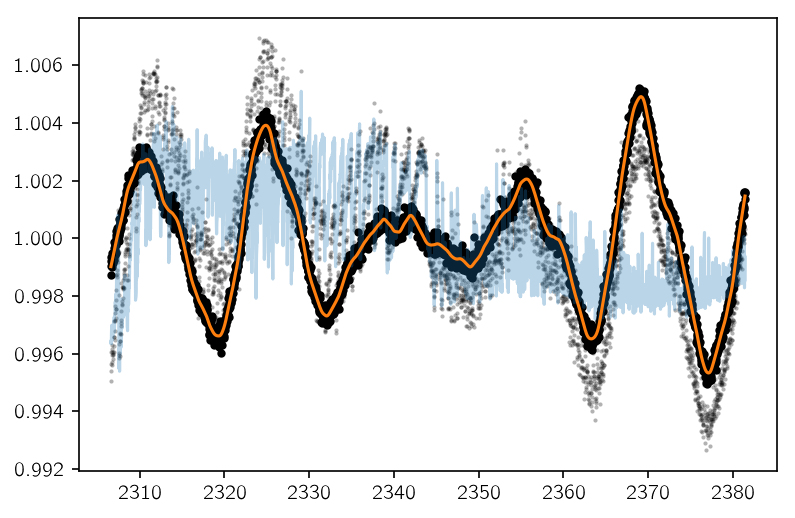

In [10]:
pld_pred, gp_pred = model.get_predictions()

fdet = model.fsap - pld_pred

plt.plot(model.t, model.fsap, ".k", alpha=0.3, ms=4, mec="none")
plt.plot(model.t, fdet, ".k")
plt.plot(model.t, pld_pred + 1.0, alpha=0.3)
plt.plot(model.t, gp_pred)

In [11]:
model.period

14.603409586538717

In [12]:
model.pld.get_parameter_dict()

OrderedDict([('log_lambda_0', 0.016596276400981741),
             ('log_lambda_1', -0.013067201956754019),
             ('log_lambda_2', -0.013100512282033492),
             ('log_lambda_3', -0.013922173761030063),
             ('log_lambda_4', 0.0015156096236093458)])

In [13]:
period_ind = model.gp.get_parameter_names().index("kernel:terms[1]:log_P")
period_ind

5

In [16]:
from multiprocessing import Pool
import emcee

# def custom_move(coords, random):
#     sgn = 2*(random.rand(len(coords)) < 0.5) - 1
#     c = np.array(coords)
#     c[:, period_ind] += sgn * np.log(2.0)
#     return c, np.zeros(len(coords))

# moves = [
#     (emcee.moves.StretchMove(), 0.8),
#     (emcee.moves.MHMove(custom_move), 0.2),
# ]
moves = emcee.moves.StretchMove()

def log_prob(params):
    model.gp.set_parameter_vector(params)
    lp = model.gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf, lp, model.period
    ll = model.gp.log_likelihood(fdet, quiet=True)
    if not np.isfinite(ll):
        return -np.inf, lp, model.period
    return ll + lp, lp, model.period

with Pool() as pool:
    init = best_params + 1e-5*np.random.randn(64, len(best_params))
    nwalkers, ndim = init.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool, moves=moves)
    sampler.run_mcmc(init, 10000, progress=True);

100%|██████████| 10000/10000 [04:46<00:00, 34.91it/s]


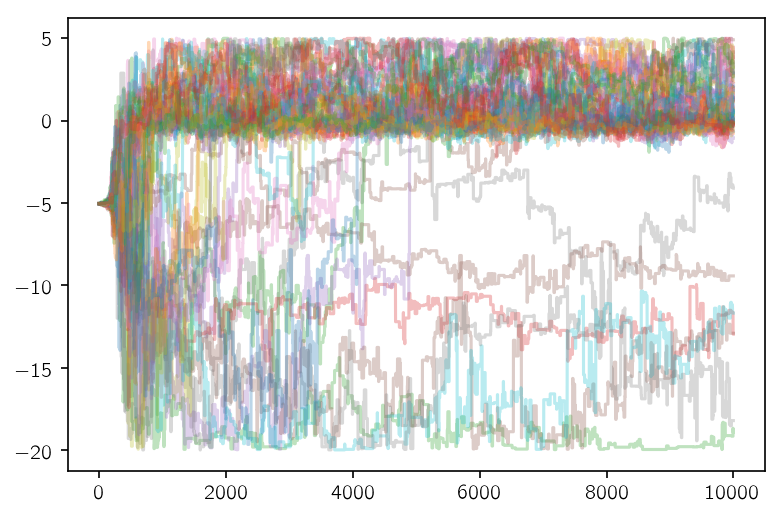

In [17]:
chain = sampler.get_chain()
plt.plot(chain[:, :, -2], alpha=0.3);

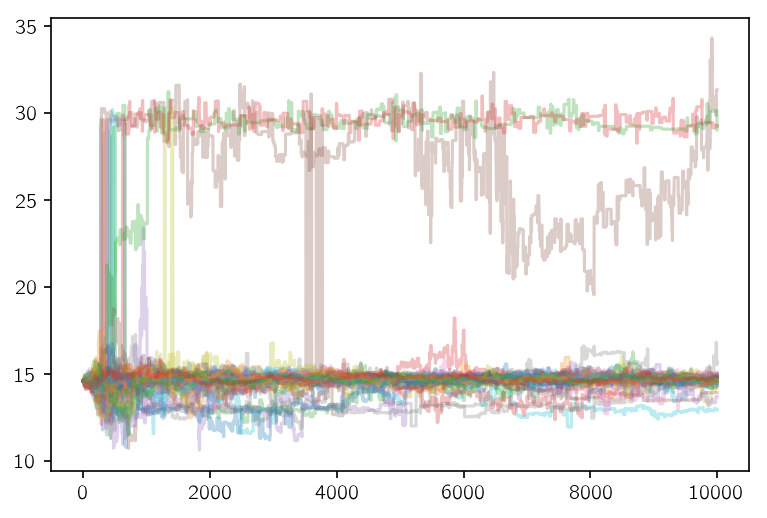

In [18]:
periods = sampler.get_blobs()[:, :, 1]
plt.plot(periods, alpha=0.3);

In [19]:
sampler.get_autocorr_time(discard=500, quiet=True)

array([ 670.63488803,  555.05968826,  725.67949116,  606.99117481,
        787.71818082,  506.54221042,  730.14028605,  723.85903875,
        723.12182729,  574.86861889])

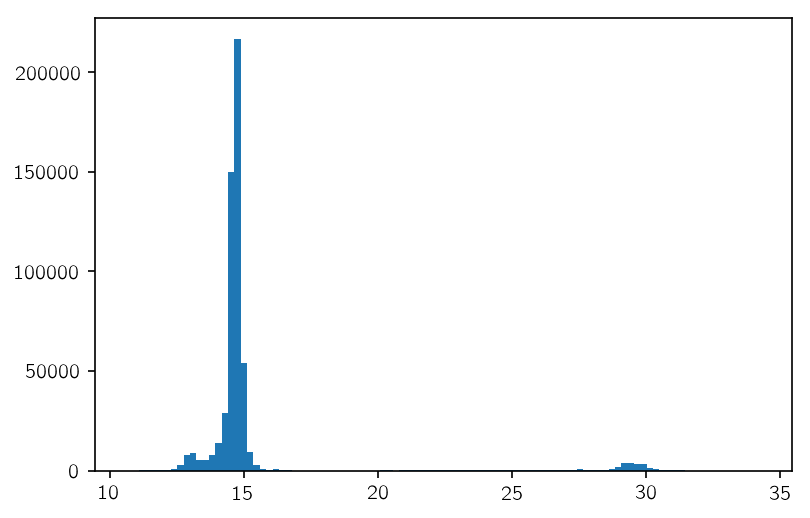

In [20]:
plt.hist(sampler.get_blobs(discard=1500, flat=True)[:, 1], 100);

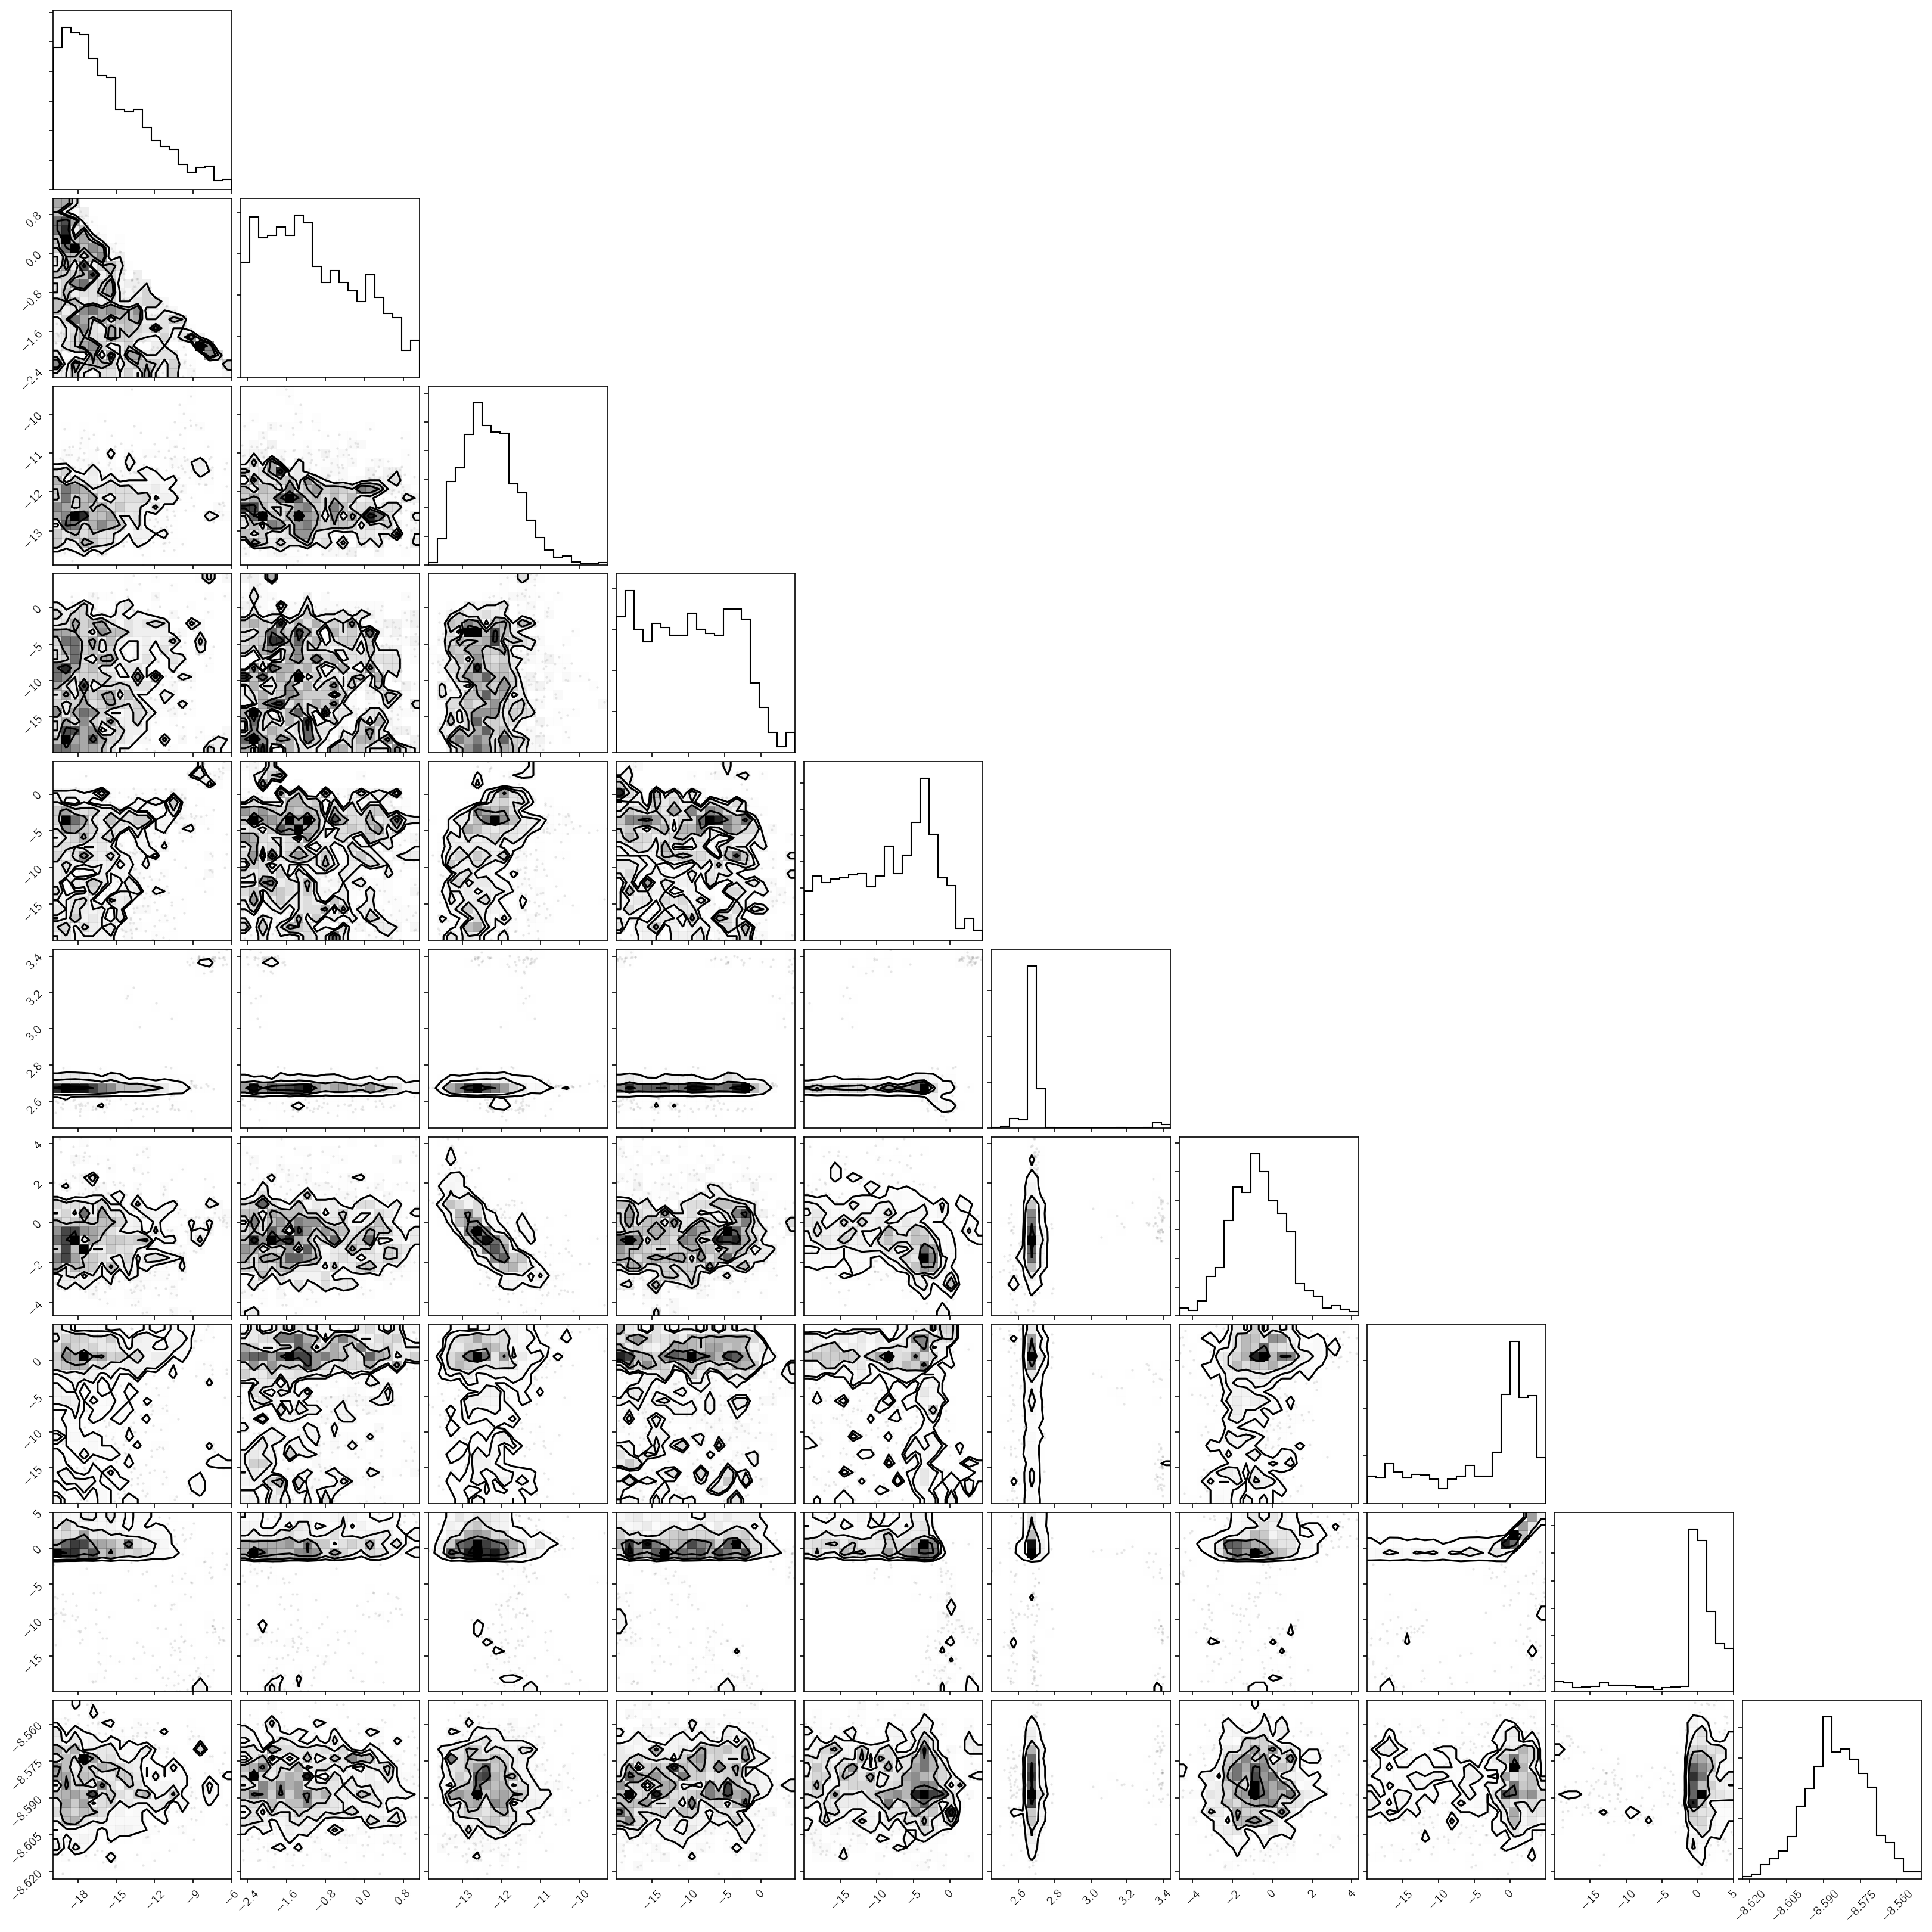

In [21]:
import corner

samples = sampler.get_chain(flat=True, discard=1500, thin=501)
corner.corner(samples);

In [22]:
model.gp.get_parameter_names()

('kernel:terms[0]:log_S0',
 'kernel:terms[0]:log_omega0',
 'kernel:terms[1]:log_a1',
 'kernel:terms[1]:log_b1',
 'kernel:terms[1]:log_f1',
 'kernel:terms[1]:log_P',
 'kernel:terms[1]:mix_par',
 'kernel:terms[1]:log_b2',
 'kernel:terms[1]:log_f2',
 'kernel:terms[2]:log_sigma')

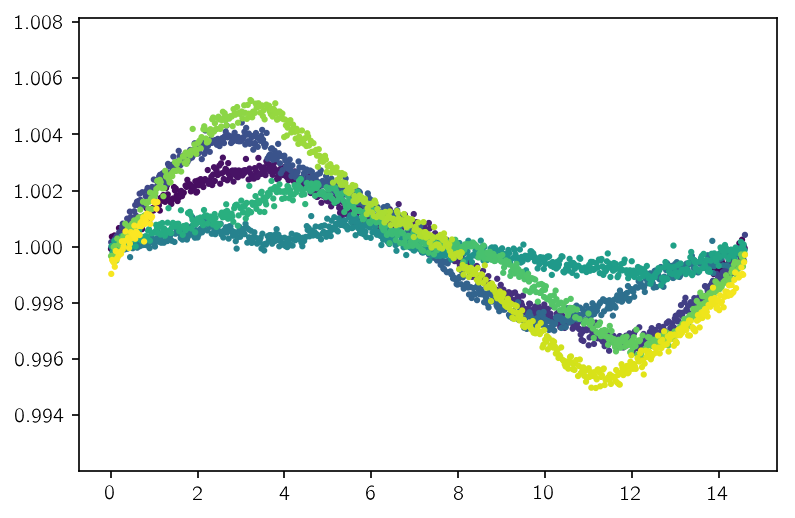

In [23]:
# pld_pred, gp_pred = model.get_predictions()
# fdet = model.fsap - pld_pred
period = model.period

#plt.plot(model.t % period, model.fsap, ".k", alpha=0.3, ms=4, mec="none")
plt.scatter(model.t % period, fdet, c=model.t, s=4)

In [24]:
model.period * 24

350.48183007692921